# Граф друзей VK

Импортируем все необходимое

In [1]:
import sqlite3
import requests
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
#cursor.execute("""DROP Table friends""")

Подключаемся к БД, создаем таблицу

In [3]:
conn = sqlite3.connect('my_friends.db')
cursor = conn.cursor()

cursor.execute("""CREATE TABLE friends 
                    (friend_id int, first_name text, last_name text, bdate text, city text, sex int,
                    occupation_name text)  
                """)

Инициализируем id и token

In [4]:
#my_id = 'zhizhevoy'
my_id = '128986903'
access_token = '170ff153170ff153170ff153ee177ba4ae1170f170ff153488e76b4ea08ed70d8351c4f'
#access_token = 'u9MXAqfZwXGLArPmXwqB'
#access_token='vk1.a.HjJehacBzpm-UGQF_B4A5gWPVS7lqw3Fh-P56FeRggnRWQ-zwzNgX3NjK-HwDFanjt5ZUs01lqz-7imALNGgQhtcCepQZtuYsDng-5E_CxA-6AOnATbpT15RK-oNLaBRSk12-I8CtWNOriV9RTERC3ie6CiFYfag2GzI870TVAXGF23zvD8FDYWC6CRv80oD'

Link VK API

In [5]:
#link = "https://api.vk.com/method/users.get?user_id="+my_id+"&lang=0&fields=bdate,country, city, universities,occupation,schools,sex&v=5.199&access_token=" + access_token
link = "https://api.vk.com/method/users.get?user_id="+my_id+"&lang=0&fields=country&v=5.199&access_token=" + access_token

In [6]:
link

'https://api.vk.com/method/users.get?user_id=128986903&lang=0&fields=country&v=5.199&access_token=170ff153170ff153170ff153ee177ba4ae1170f170ff153488e76b4ea08ed70d8351c4f'

Запросы

In [7]:
response = requests.get(link)
#print(response.status_code)
tree = response.json()['response']#превращает запрос в формат json

print(tree)



[{'id': 128986903, 'first_name': 'Алексей', 'last_name': 'Илямаков', 'can_access_closed': True, 'is_closed': False}]


In [8]:
link = "https://api.vk.com/method/friends.get?user_id="+my_id+"&lang=0&fields=bdate,city, universities,occupation,schools,sex&v=5.199&access_token=" + access_token
#link = "https://api.vk.com/method/friends.get?user_id="+my_id+"&lang=0&fields=sex&v=5.199&access_token=" + access_token

response = requests.get(link)
#print(response.status_code)
my_friends = response.json()['response']['items']#превращает запрос в формат json

my_friends[0]

{'id': 770150,
 'bdate': '26.7',
 'occupation': {'id': 871,
  'name': 'УлГУ (бывш. филиал МГУ)',
  'type': 'university',
  'graduate_year': 1999,
  'city_id': 149},
 'track_code': '2e1801b0mrp0aRk0Xx9nif_a8MNciOFHeQ0_eP4PbeZqQUu2mLX30SpZKmAMGTSPz2laT7rnllMLZFoW',
 'sex': 1,
 'first_name': 'Елена',
 'last_name': 'Богданова',
 'can_access_closed': False,
 'is_closed': True}

Заполняем таблицу

In [9]:
for id_friend in my_friends:
    friend_id = id_friend['id']
    try:
        first_name = id_friend['first_name']
    except KeyError:
        first_name = ""
    try:
        last_name = id_friend['last_name']
    except KeyError:
        last_name = ""
    try:
        bdate = id_friend['bdate']
    except KeyError:
        bdate = ""
    try:
        sex = id_friend['sex']
    except KeyError:
        sex = ""
    try:
        city = id_friend['city']['title']
    except KeyError:
        city = ""
    try:
        occupation = id_friend['occupation']['name']
    except KeyError:
        occupation = ""

    #print(friend_id, first_name, last_name, bdate, sex, city, occupation)
    cursor.execute('INSERT INTO friends VALUES(?,?,?,?,?,?,?)', (friend_id, first_name, last_name, bdate, city, sex, occupation))
    conn.commit()

In [10]:
cursor.execute("SELECT friend_id  FROM friends")
res = cursor.fetchall()
my_friends=[x[0] for x in res]


Создаем и рисуем граф

In [11]:
G = nx.Graph()
G.add_node(my_id)
print(G)

Graph with 1 nodes and 0 edges


In [12]:
def draw_graph(G, color,legend_elements):
    hub_ego = nx.ego_graph(G, my_id)
    pos = nx.spring_layout(hub_ego)
    plt.rcParams["figure.figsize"] = (30,15)
    nx.draw(hub_ego, pos, node_color=color, node_size=550, with_labels=False)
    plt.legend(handles=legend_elements,loc=3, prop={'size': 30})
    plt.show()

In [13]:
for id_friend in my_friends:
    G.add_node(id_friend)
    G.add_edge(my_id, id_friend)


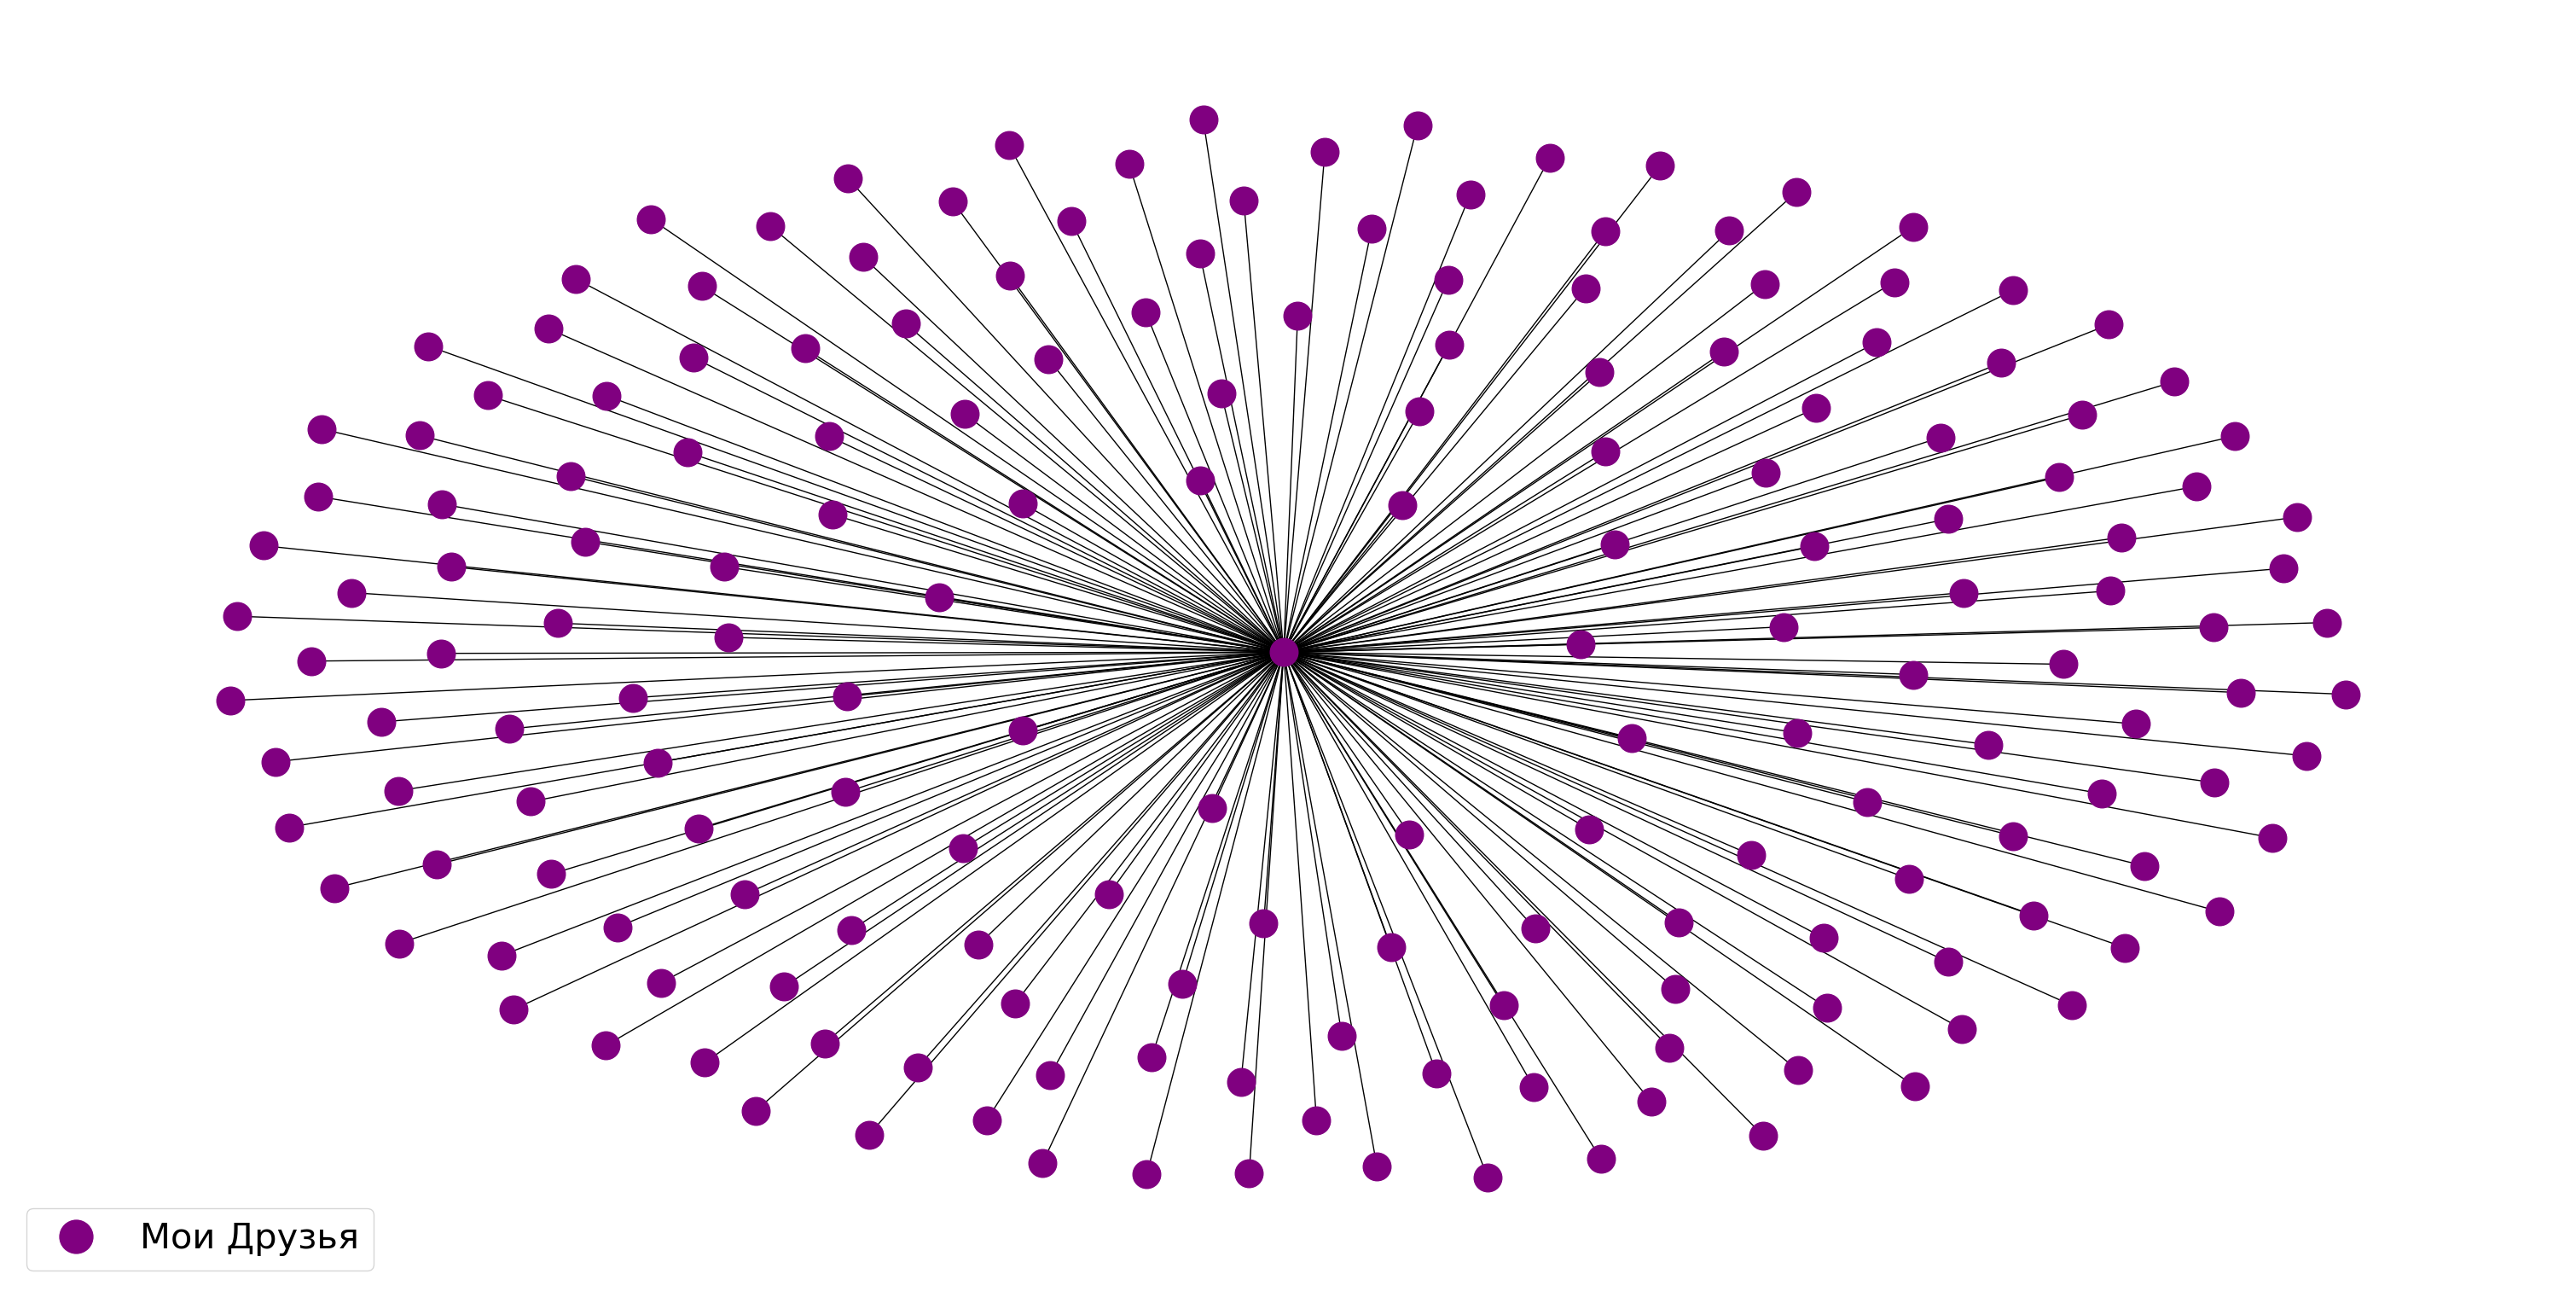

In [14]:
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Мои Друзья',
                          markerfacecolor='purple', markersize=30)]
draw_graph(G, 'purple', legend_elements)

In [15]:
node_color = []
for _id in G:
    #sex = cursor.fetchone()[0]
    if (_id == my_id):
        node_color.append('white')
    else:
        sql = "SELECT sex FROM friends where friend_id = ?"
        cursor.execute(sql,[_id])
        try:
            sex = cursor.fetchone()[0]
            #print(sex)
            if (sex == 1):
                node_color.append('purple')
            else:
                node_color.append('darkblue')
        except:
            #node_color.append('white')
            print(_id)


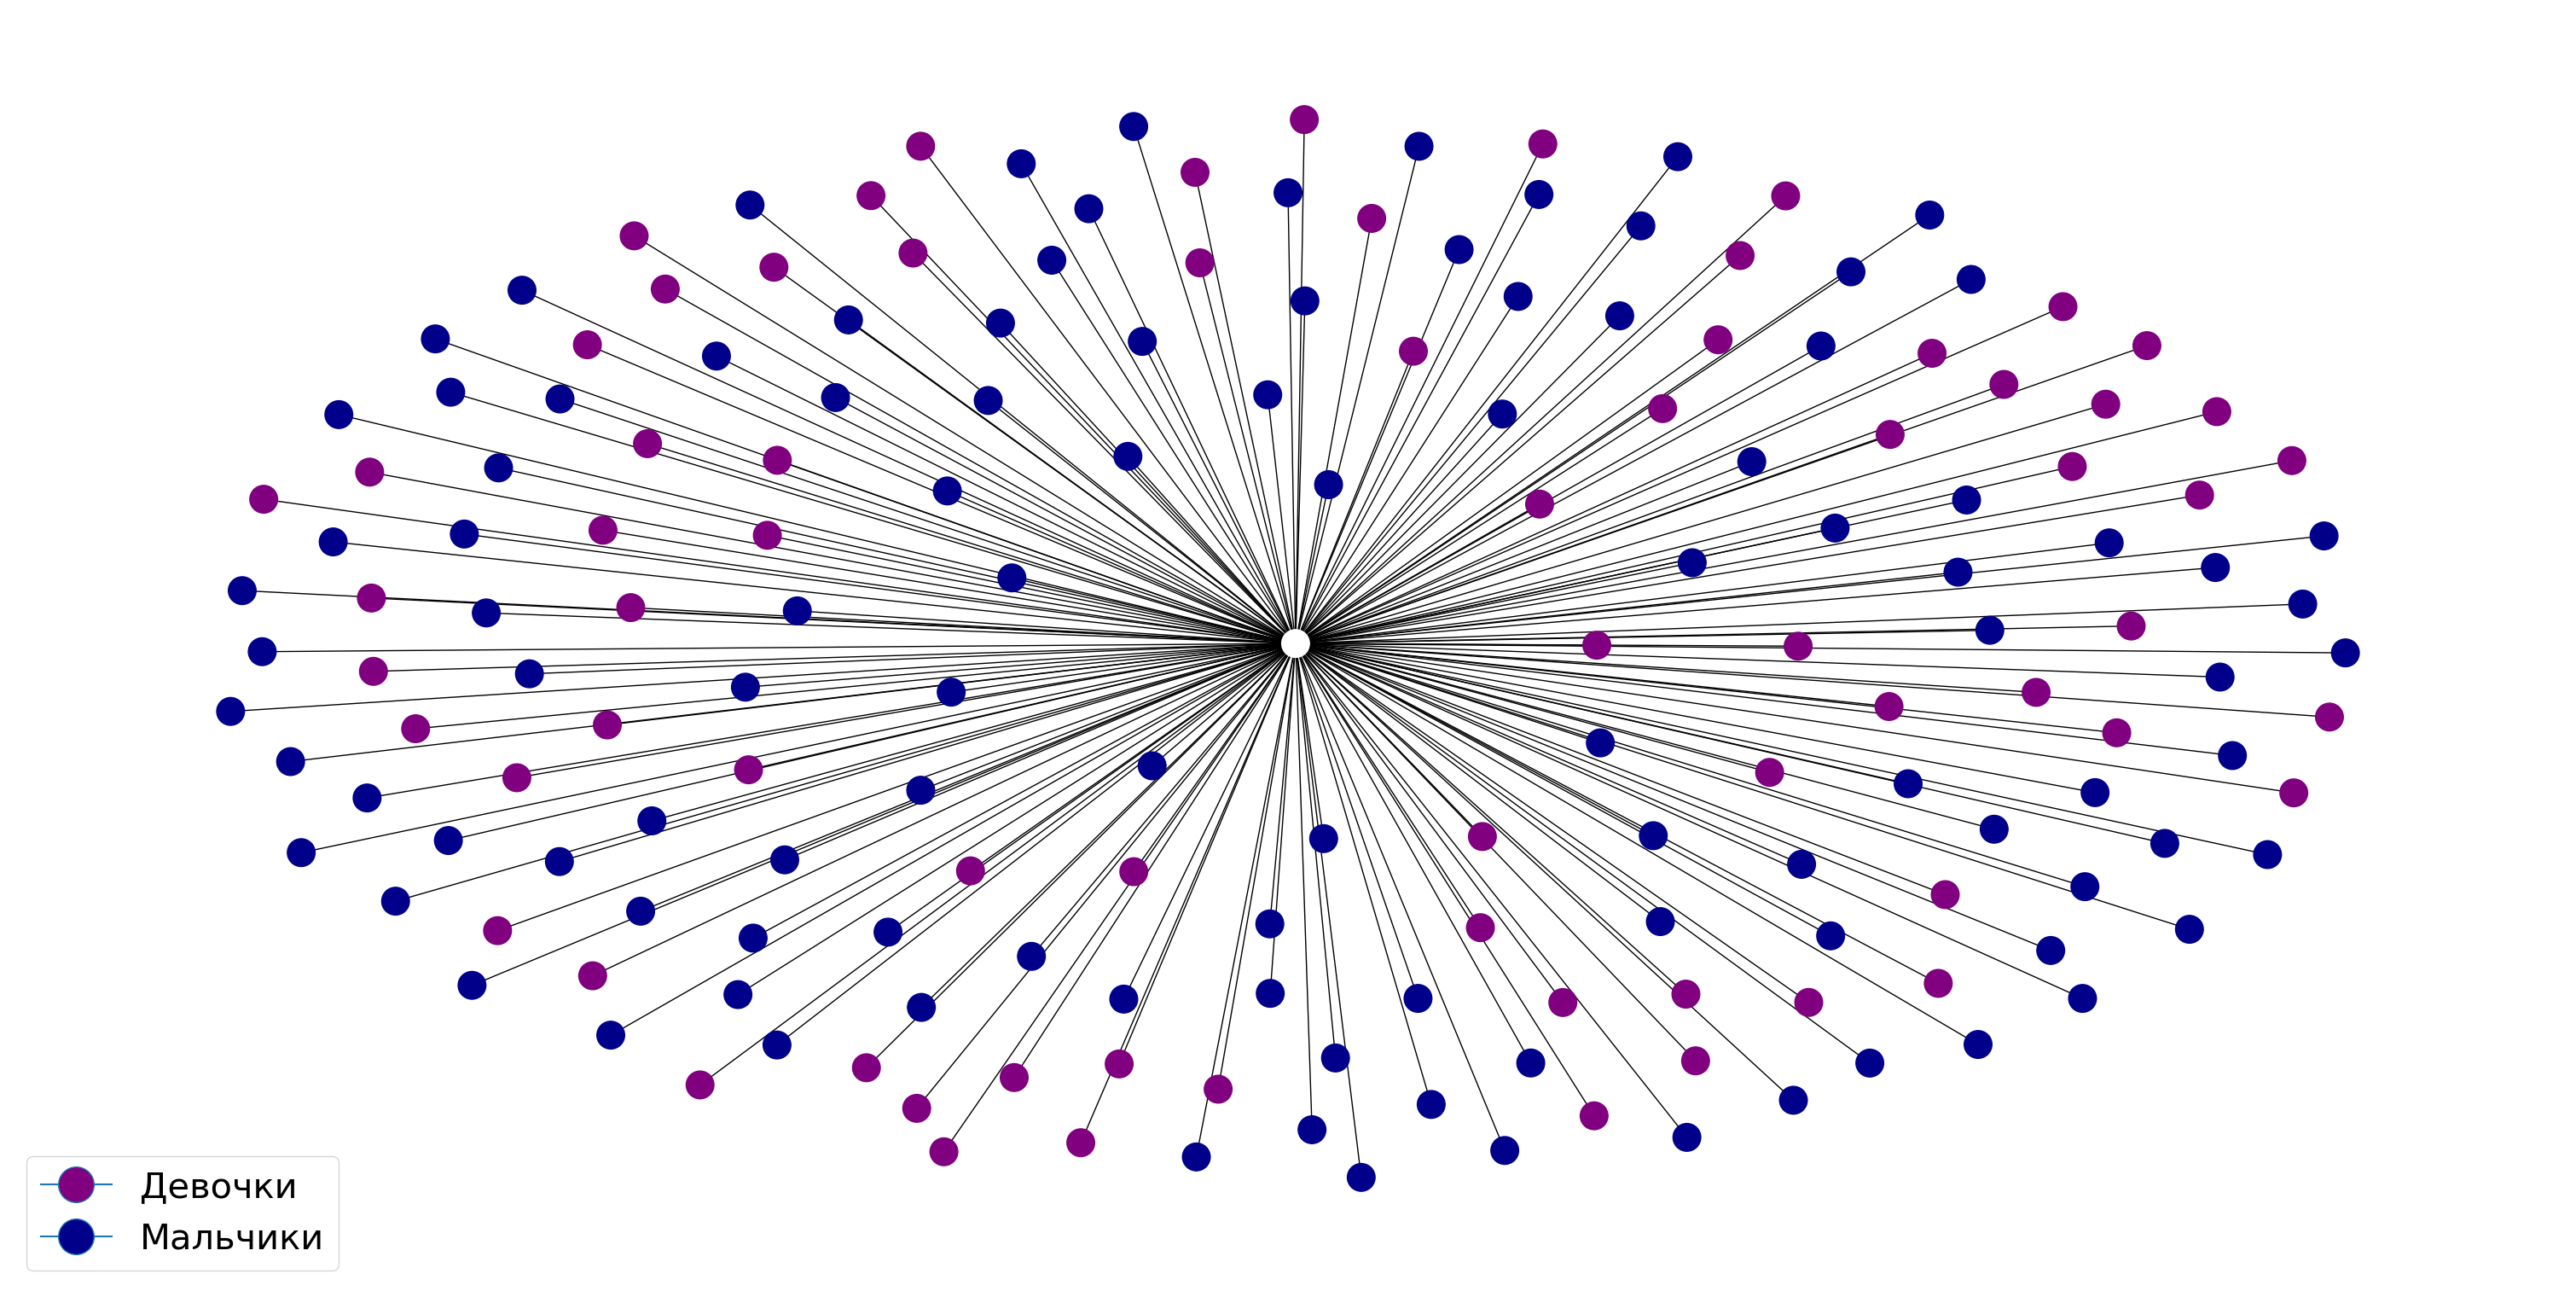

In [16]:
legend_elements = [Line2D([0], [0], marker='o',  label='Девочки',
                          markerfacecolor='purple', markersize=30),
                  Line2D([0], [0], marker='o',  label='Мальчики',
                          markerfacecolor='darkblue', markersize=30)]
draw_graph(G, node_color,legend_elements)
